In [16]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.optimize import fsolve
import pandas as pd
from scipy.optimize import curve_fit

In [17]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=6):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

# INFORMAÇÕES DO SISTEMA
- Declarando a função de transferência e obtendo os parâmetros

In [18]:
s = ctl.TransferFunction.s
G = 1/(s**2 + 2*s)

G_bkp = G
G

TransferFunction(array([1]), array([1, 2, 0]))

polos:  (-2+0j) 0j
zeros: 


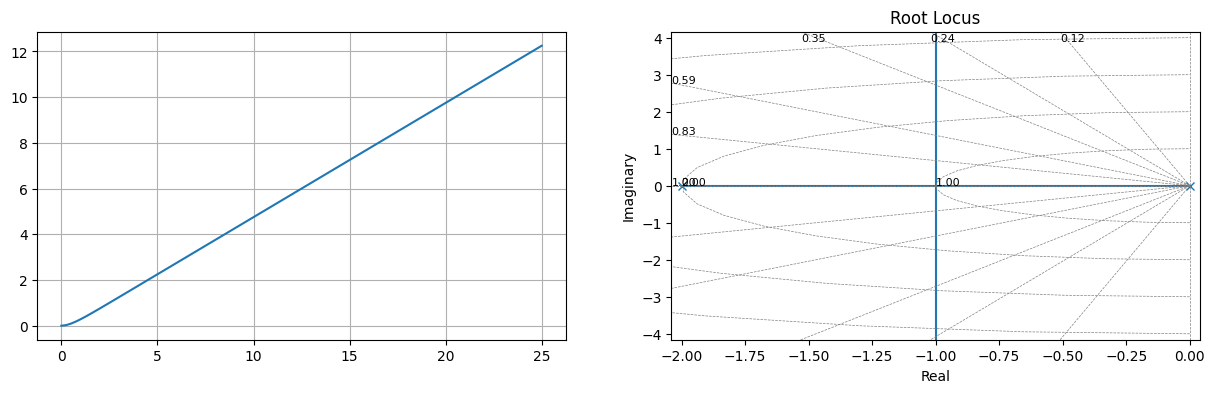

In [19]:
poles = ctl.poles(G)
zeros = ctl.zeros(G)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G)
plt.show()

# INFORMAÇÕES DA RESPOSTA

In [20]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, show=False)

{'overshoot': 0.0,
 'peakValue': 12.249999999999996,
 'peakTime': 25.0,
 'settlingTime': None,
 'finalValue': 12.249999999999996,
 'error': 11.249999999999996}

# CONTROLADOR
- Encontrando as constantes do controlador $C(s)$

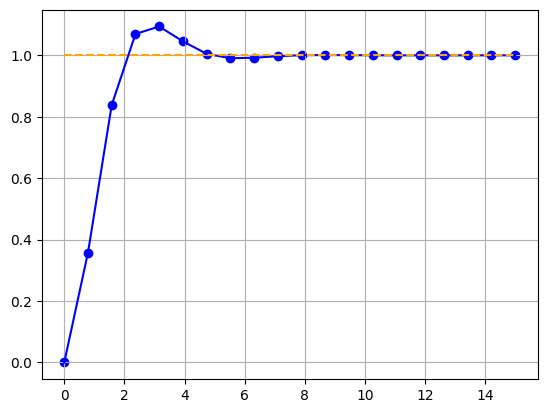

In [21]:
Ts = 5
UP = 0.1

zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
Wn = 4/(zeta*Ts)

s = ctl.TransferFunction.s
T = np.linspace(0, Ts*3, 20)

tData, desired = ctl.step_response(Wn**2/(s**2 + 2*zeta*Wn*s + Wn**2), T=T)
plt.scatter(tData, desired, color='blue')
plt.plot(tData, desired, color='blue')
plt.plot(tData, [1 for i in tData], '--', color='orange')
plt.grid()

In [22]:
def C(s, a, b, c, d, e, f):
    s = ctl.TransferFunction.s
    G_c = (a*s**2 + b*s + c)/(d*s**2 + e*s + f)
    
    G_feedback = ctl.feedback(G*G_c, 1)
    return ctl.step_response(G_feedback, T=tData)[1] # response

def getFunction(xDados, yDados):
    coeficientes = curve_fit(C, xDados, yDados, maxfev=1000000000)  # MÁXIMO DE ITERAÇÕES
    return list(coeficientes[0])

In [23]:
coefs = getFunction(tData, desired)  
coefs

[3.4399635048022477,
 11.893819479841378,
 10.027784940473575,
 1.878350544911379,
 5.743136328036446,
 4.380440729885111]

In [24]:
a, b, c, d, e, f = coefs
C = (a*s**2 + b*s + c)/(d*s**2 + e*s + f)
C

TransferFunction(array([ 3.4399635 , 11.89381948, 10.02778494]), array([1.87835054, 5.74313633, 4.38044073]))

In [25]:
G_feedback = ctl.feedback(G*C, 1)
G_feedback

TransferFunction(array([ 3.4399635 , 11.89381948, 10.02778494]), array([ 1.87835054,  9.49983742, 19.30667689, 20.65470094, 10.02778494]))

- Como todos os polos do sistema em malha fechada estão no semiplano esquerdo, o sistema é estável

In [26]:
[np.round(val, 3) for val in list(ctl.poles(G_feedback))]

[(-0.8+1.092j), (-0.8-1.092j), (-2+0j), (-1.458+0j)]

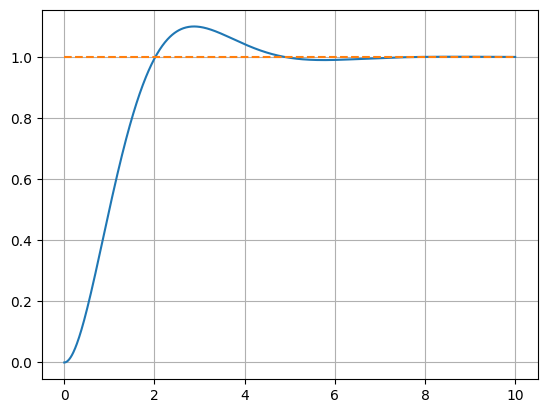

In [27]:
tData = np.linspace(0, Ts*2, 1000)

time, response = ctl.step_response(G_feedback, T=tData)
plt.plot(time, response)
plt.plot(time, [1 for i in time], '--')
plt.grid()